In [22]:
import torch
import torchvision
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os
import shutil
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim import SGD, Adam, lr_scheduler
import torch.utils.data
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

CSV_MODEL_PATH = "DenseNet_train_log.csv"

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 1070 Ti'

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [6]:
def train_dataloader(train_transform, batch_size = 64, num_workers = 0, shuffle = True):
    transformer = train_transform
    cifar_training = datasets.CIFAR10(root='.',train=True, download=True, transform=transformer)
    cifar_loader = DataLoader(cifar_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)
    return cifar_loader

def test_dataloader(test_transform, batch_size = 64, num_workers = 0, shuffle = True):
    transformer = test_transform
    cifar_test = datasets.CIFAR10(root='.', train = False, download = True, transform = transformer)
    cifar_loader = DataLoader(cifar_test, shuffle = shuffle, num_workers = num_workers, batch_size = batch_size)
    return cifar_loader

Getting the dataset and putting into the correct format.

Once files are downloaded this section can be run as many times as needed, and file won't re-download.

In [7]:
train_loader = train_dataloader(train_transform)
test_loader = test_dataloader(test_transform)

Files already downloaded and verified
Files already downloaded and verified


### Viewing the dataset.

The CIFAR10 dataset consists 60,000 32x32 images of 10 image classes. Each class has 6000 images. 5000 images are for the training and 1000 of the images are used for testing.

#### Below are 25 example images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

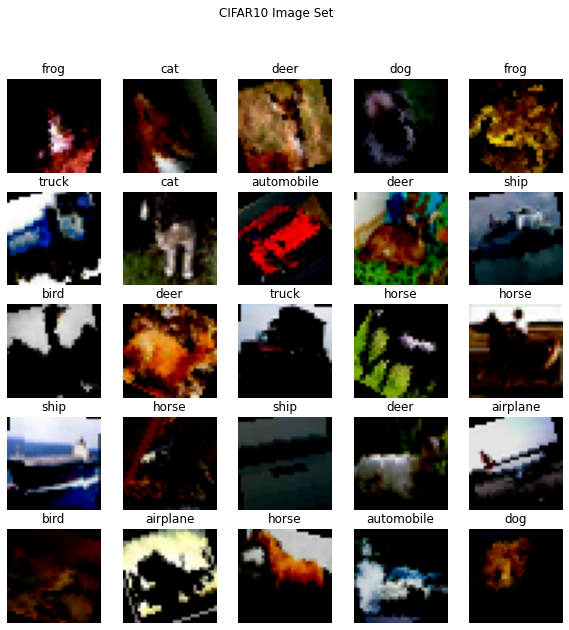

In [8]:
image_classes = {0 : 'airplane', 1 :'automobile', 2 : 'bird', 3 : 'cat', 4 :'deer', 5 :'dog', 6 : 'frog', 
                 7 :'horse', 8 : 'ship', 9 :'truck'}
# plot 25 random images from training dataset
fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
for batch_idx, (inputs, labels) in enumerate(train_loader):
    for im in range(25):
        image = inputs[im].permute(1, 2, 0)
        i = im // 5
        j = im % 5
        axs[i,j].imshow(image.numpy()) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(image_classes[int(labels[im].numpy())])
        
    break;

# set suptitle
plt.suptitle('CIFAR10 Image Set')
plt.show()

In [9]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channel = 4 * growth_rate
        
        self.bottle_neck = nn.Sequential(
        nn.BatchNorm2d(in_channels), nn.ReLU(inplace=True),
        nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
        nn.BatchNorm2d(inner_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(inner_channel, growth_rate, 
                  kernel_size=3, padding=1, bias=False))
        
    def forward(self, x):
        return torch.cat([x,self.bottle_neck(x)],1)

In [10]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.down_sample = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels, out_channels, 1, bias=False),
        nn.AvgPool2d(2, stride=2))
        
    def forward(self, x):
        return self.down_sample(x)

In [11]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super().__init__()
        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)
        self.features = nn.Sequential()
        ##Adding multiple blocks
        for idx in range(len(nblocks)-1):
            self.features.add_module("dense_block_layer_{}".format(idx),
                                     self._make_dense_layers(block, inner_channels, nblocks[idx]))
            inner_channels += growth_rate * nblocks[idx]
            out_channels = int(reduction * inner_channels)
            self.features.add_module("transition_block_layer_{}".format(idx),
                                    TransitionLayer(inner_channels, out_channels))
            inner_channels = out_channels
        
        self.features.add_module("dense_block_{}".format(len(nblocks)-1),
                                self._make_dense_layers(block, inner_channels,
                                nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module("bn",nn.BatchNorm2d(inner_channels))
        self.features.add_module("activation", nn.ReLU(inplace=True))
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0],-1)
        output = self.linear(output)
        return output
    
    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for idx in range(nblocks):
            dense_block.add_module("bottleneck_block_layer_{}".format(idx),
                                  block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block
    
    #
    #defining the densenet121 model
    #other models versions to be added later
    #
def densenet121(activation = 'relu'):
    return DenseNet(BottleneckBlock, [6,12,24,16], growth_rate=32)
            
        

In [12]:
epochs = 25
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device
#inputs = inputs.cuda()
#labels = labels.cuda()

device(type='cuda', index=0)

**NOT REUQUIRED** unless you wish to train the model yourself.

In [13]:
model = densenet121()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = learning_rate)
train_stats = pd.DataFrame(columns=['Epoch', 'Time per epoch', 'Avg time per step',
                                   'Train loss', 'Train accuracy', 'Train top-3 accuracy',
                                   'Test loss', 'Test accuracy', 'Test top-3 accuracy'])

#### Getting everything set and training the model.
All stats from the training are saved into a dataframe and later saved to a csv file for easy viewing use.

The info measured includes: 
  - Epochs 
  - Time per Epoch
  - Train Loss
  - Train Accuracy
  - Top Train Accuracy
  - Test Loss
  - Test Accuracy
  - Top Test Accuracy.

# Training

**NOT REQUIRED** unless you wish to train the model yourself.

In [14]:
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top_train_accuracy = 0 
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        #Stupid subscripting deprecation
        running_loss += loss.item()     
        # calculate the top-1 train accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate the top train accuracies
        np_top_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top_train_accuracy += np.mean([1 if target_numpy[i] in np_top_class[i] else 0 for i in range(0, len(target_numpy))])
    #time stuff
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate top train accuracies
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate top test accuracies
            np_top_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top_test_accuracy += np.mean([1 if target_numpy[i] in np_top_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(train_loader):.4f}.. "
          f"Train loss: {running_loss/len(train_loader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(train_loader):.4f}.. "
          f"Top-3 train accuracy: {top_train_accuracy/len(train_loader):.4f}.. "
          f"Test loss: {test_loss/len(test_loader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(test_loader):.4f}.. "
          f"Top-3 test accuracy: {top_test_accuracy/len(test_loader):.4f}")

    train_stats = train_stats.append({
        'Epoch': epoch, 
        'Time per epoch':time_elapsed, 
        'Avg time per step': time_elapsed/len(train_loader), 
        'Train loss' : running_loss/len(train_loader), 
        'Train accuracy': train_accuracy/len(train_loader), 
        'Train top-3 accuracy':top_train_accuracy/len(train_loader),
        'Test loss' : test_loss/len(test_loader), 
        'Test accuracy': test_accuracy/len(test_loader), 
        'Test top-3 accuracy':top_test_accuracy/len(test_loader)}, ignore_index=True)

    running_loss = 0
    model.train()

KeyboardInterrupt: 

**NOT REUQUIRED** unless you wish to train the model yourself.

In [37]:
#dataframe is written to csv file
#should probably add something to open and visualize the stats without needing to run.
inputs = inputs.cuda()
labels = labels.cuda()
train_stats.to_csv(CSV_MODEL_PATH)
FILE = "model.pth"
torch.save(model.state_dict(), FILE)


### Graphing the Training and Test loss

**NOT REUQUIRED** unless you wish to train the model yourself.

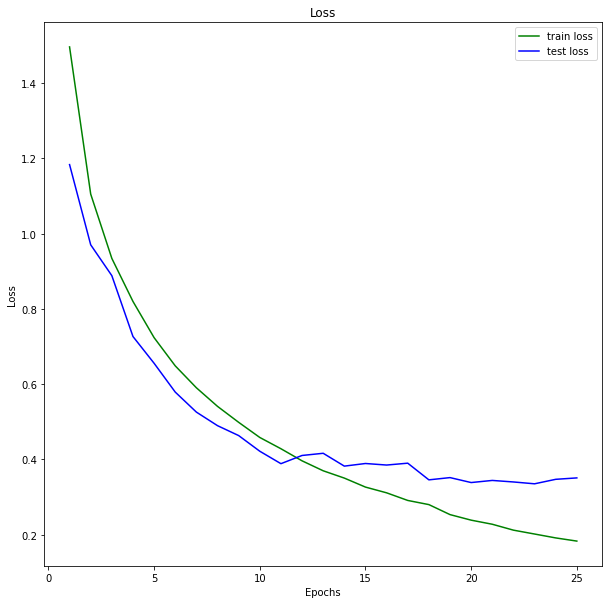

In [38]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss')
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss')
plt.legend()

### Graphing the Accuracy of the model
After just 10 epochs the train accuracy is just under 90%.

After about 17 epochs the test accuracy starts to plateau.

**NOT REUQUIRED** unless you wish to train the model yourself.

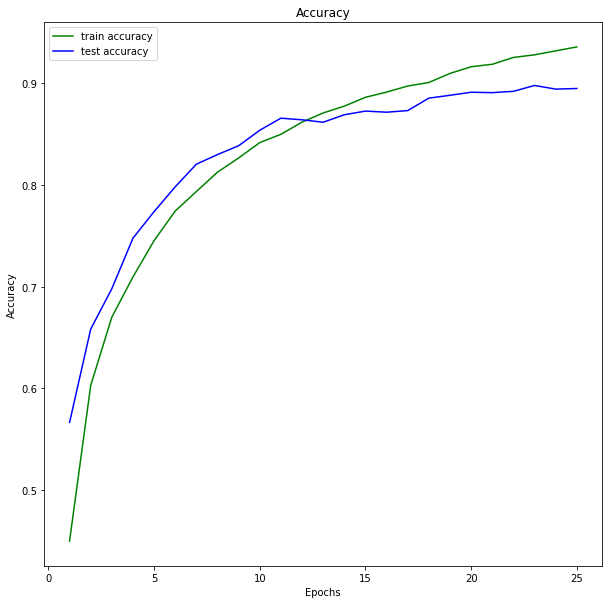

In [39]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy')
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy')
plt.legend()

In [15]:
def view_classification(image, ps, title):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    image = image.permute(1,2,0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(image_classes.values()), size='small')
    ax2.set_title(title)
    ax2.set_xlim(0,1.1)
    plt.tight_layout()
    plt.show()

In [41]:
torch.cuda.empty_cache()

### View Predictions
The label of the bar graph is the correct label for the image.

The bars represent the models classification.

**NOT REUQUIRED** unless you wish to train the model yourself. Use the other one for the loaded model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


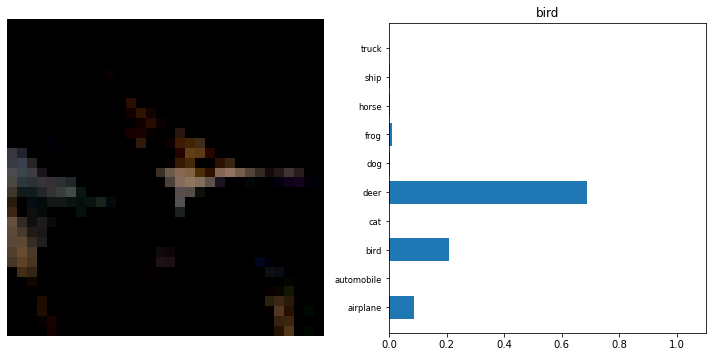

In [44]:
for idx, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classification(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), image_classes[int(label_true.cpu().numpy())])
    break

# Loading the trained model data.

In [33]:
FILE = "model.pth"
loaded_model = densenet121()
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()
loaded_model.to(device)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottleneck_block_layer_0): BottleneckBlock(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottleneck_block_layer_1): BottleneckBlock(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
         

# Loaded Model for use Without Training. #
*Make sure you run the appropriate cells to initialize all needed variables.*

If the cell is marked **NOT REQUIRED** above it, then it is not required unless you wish to train the model.

### Loaded data from the saved model used for inference.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


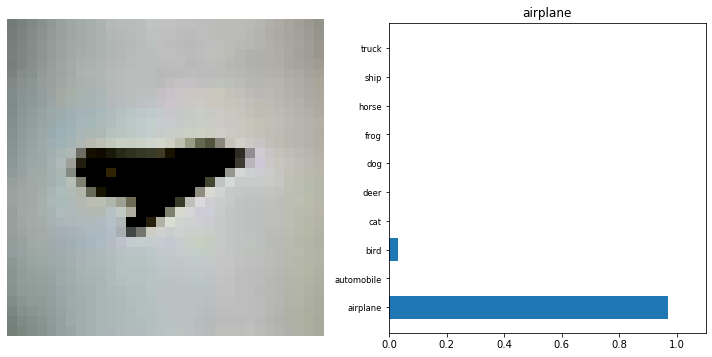

In [34]:
inputs = inputs.cuda()
labels = labels.cuda()
for idx, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = loaded_model(inputs)
    view_classification(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), image_classes[int(label_true.cpu().numpy())])
    break

In [35]:
loaded_stats = pd.read_csv(CSV_MODEL_PATH)
#loaded_stats.head() #debugging

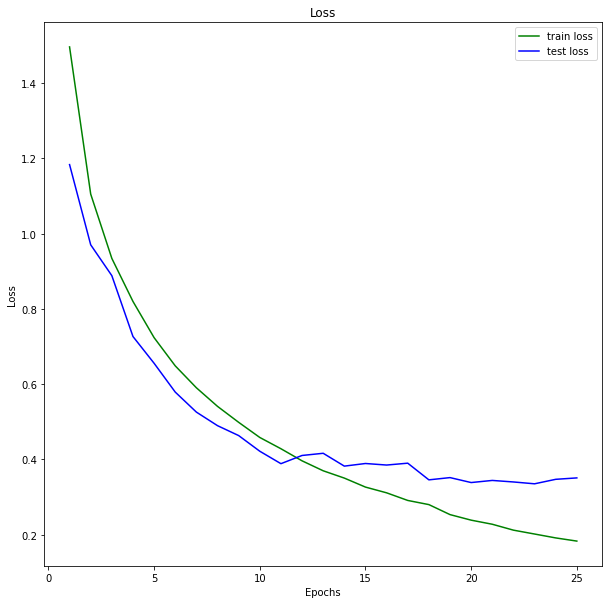

In [36]:
def show_loss_csv():
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    x = range(1, len(loaded_stats['Train loss'].values) + 1)
    ax.plot(x, loaded_stats['Train loss'].values, '-g', label='train loss')
    ax.plot(x, loaded_stats['Test loss'].values, '-b', label='test loss')
    plt.legend()

show_loss_csv()

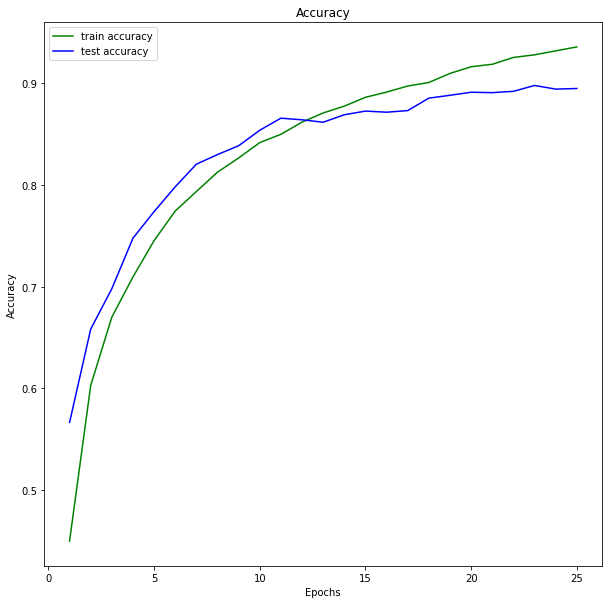

In [37]:
def show_acc_csv():
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    x = range(1, len(loaded_stats['Train accuracy'].values) + 1)
    ax.plot(x, loaded_stats['Train accuracy'].values, '-g', label='train accuracy')
    ax.plot(x, loaded_stats['Test accuracy'].values, '-b', label='test accuracy')
    plt.legend()
    
show_acc_csv()